##Ensemble Voting Model
1. Logistic Regression with CV
2. Naive Bayes
3. Combine

In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [88]:
text_column = ['reviews']
num_columns = ['track_popularity', 'discovery',
             'familiarity','hotttnesss','acousticness',
             'danceability','duration','energy','instrumentalness',
             'liveness','loudness','speechiness','tempo',
             'valence']
target_column = ['love']
data = pd.read_csv('playlist_with_reviews.csv', index_col=1)
data[text_column] = data[text_column[0]].apply(
            lambda x: unicode(x, errors='replace'))
data[text_column] = data[text_column[0]].apply(
            lambda x: x if len(x) > 100 else np.nan)
data = data[text_column + num_columns + target_column]
data.dropna(inplace=True)

# print data['reviews'].filter(lambda x: len(x) > 1000)
# data.drop(data[(len(data['reviews'] < 1000))])
print data.shape
data.columns

(93, 16)


Index([u'reviews', u'track_popularity', u'discovery', u'familiarity',
       u'hotttnesss', u'acousticness', u'danceability', u'duration', u'energy',
       u'instrumentalness', u'liveness', u'loudness', u'speechiness', u'tempo',
       u'valence', u'love'],
      dtype='object')

In [153]:
import random
train_idxs = np.array(random.sample(
        range(data.shape[0]), data.shape[0]/3))
mask = np.ones(len(data), dtype=bool)
mask[train_idxs] = False

target_train = data[target_column].ix[mask]
target_test = data[target_column].ix[~mask]

print target_train.shape
print target_test.shape

num_data = data[num_columns]

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
num_data = scaler.fit_transform(num_data)

num_train = num_data[mask]
num_test = num_data[~mask]

print num_train.shape
print num_test.shape

(62, 1)
(31, 1)
(62, 14)
(31, 14)


##Logistic Regression
1. Normalize Data 
2. Split into training and testing


accuracy score:  0.612903225806


/Users/davidgoldberg/anaconda/lib/python2.7/site-packages/sklearn/linear_model/logistic.py:1333: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  DataConversionWarning


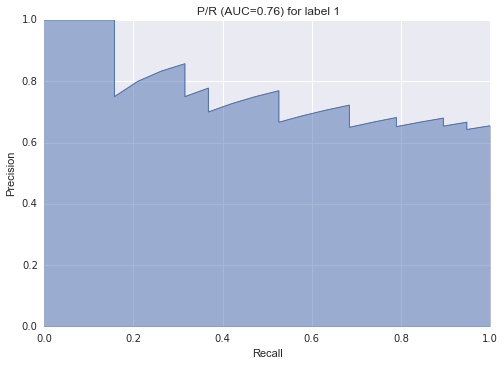

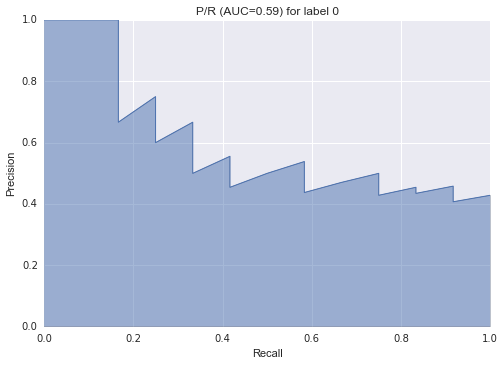

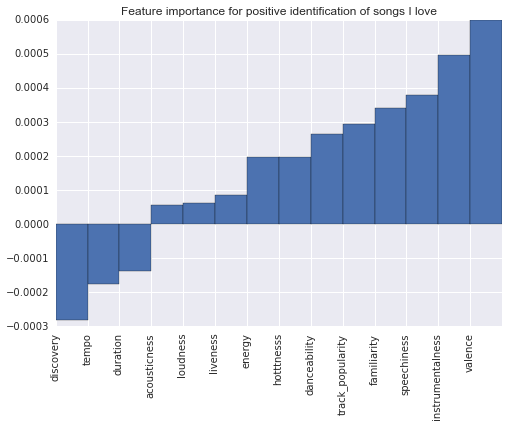

In [176]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import precision_recall_curve, auc, \
                            classification_report, f1_score

def plot_pr(proba, Y_test, pos_label=1):
    precision, recall, thresholds = precision_recall_curve(
            Y_test, 
            proba[:,pos_label], 
            pos_label=pos_label)
    plt.figure()
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.grid(True)
    plt.fill_between(recall, precision, alpha=0.5)
    plt.plot(recall, precision, lw=1)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('P/R (AUC=%0.2f) for label %d' % (auc(recall, precision), 
                                                pos_label))
    
def plot_feature_importance(feature_names, coef_, name=''):
    plt.figure()

    coef = coef_.ravel()
    
    inds = np.argsort(coef)
    feature_names = np.array(feature_names)
    feature_names = feature_names[inds]
    coef = coef[inds]

    
    xpos = np.array(list(range(len(coef))))
    plt.bar(xpos, coef, width=1)

    plt.title('Feature importance for positive identification of songs I love')
    ax = plt.gca()
    ax.set_xticks(np.arange(len(coef)))
    labels = ax.set_xticklabels(feature_names)
    for label in labels:
        label.set_rotation(90)
        

logistic = LogisticRegressionCV(cv=10,
                                scoring='f1')
logistic.fit(num_train, target_train)
proba = logistic.predict_proba(num_test)
print 'accuracy score: ', logistic.score(num_test, target_test)

plot_pr(proba, target_test, pos_label=1)
plot_pr(proba, target_test, pos_label=0)
plot_feature_importance(num_columns, logistic.coef_)

####Potential Improvements:
*  change cv scoring funciton to use f1-score

##Naive Bayes


In [253]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score
from sklearn.cross_validation import ShuffleSplit

def create_ngram_model(params=None):
    tfidf_ngrams = TfidfVectorizer(ngram_range=(1,3),
                                   analyzer='word',
                                   binary=False)
    clf = MultinomialNB()
    pipeline =  Pipeline([('vect', tfidf_ngrams),
                          ('clf', clf)])
    if params:
        pipeline.set_params(**params)
    
    return pipeline

def train_model(clf, X, Y, pos_label=1, plot=True, name='NB ngram'):
    cv = ShuffleSplit(n=len(X), n_iter=10, 
                test_size=0.3, random_state=0)
    scores = []
    pr_scores = []
    precisions, recalls, thresholds = [], [], []
    clfs = []
    
    for train, test in cv:
        
        X_train, Y_train = X.ix[train], Y.ix[train]
        X_test, Y_test = X.ix[test], Y.ix[test]
        
        clf.fit(X_train, Y_train)
        clfs.append(clf)
        
        train_score = clf.score(X_train, Y_train)
        test_score = clf.score(X_test, Y_test)
        
        scores.append(test_score)
        proba = clf.predict_proba(X_test)
        
        precision, recall, pr_thresholds = \
                precision_recall_curve(Y_test, proba[:,pos_label], pos_label=pos_label)
        
        pr_scores.append(auc(recall, precision))
        precisions.append(precision)
        recalls.append(recall)
        thresholds.append(pr_thresholds)
        
    scores_to_sort = pr_scores
    median = np.argsort(scores_to_sort)[len(scores_to_sort)/2]
    
    return clfs[median]

In [249]:
print type(data[text_column].ix[0])
print type(data[text_column].reviews[0])

<class 'pandas.core.series.Series'>
<type 'unicode'>


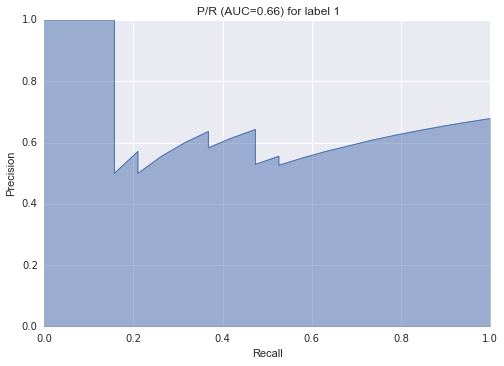

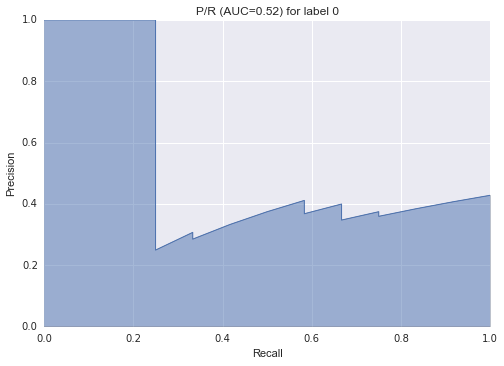

In [266]:
text_data = data[text_column].reviews

text_train = text_data[mask]
text_test = text_data[~mask]

print text_train.shape
print text_test.shape

ngram = create_ngram_model()
NB = train_model(ngram, text_train, target_train)

proba_NB = NB.predict_proba(text_test)
plot_pr(proba_NB, target_test, pos_label=1)
plot_pr(proba_NB, target_test, pos_label=0)
# plot_feature_importance(num_columns, logistic.coef_)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import f1_score
from sklearn.base import BaseEstimator
from sklearn.naive_bayes import MultinomialNB
import nltk
import re
import csv
import collections
import sys

sys.setdefaultencoding("utf-8")

def load_sent_word_net(swn_file='SentiWordNet_3.0.0_20130122.txt'):
    sent_scores = collections.defaultdict(list)
    with open(swn_file) as csvfile:
        reader = csv.reader(csvfile, delimiter='\t', quotechar='"')
        for line in reader:
            if line[0].startswith("#"): continue
            if len(line) == 1: continue
            
            POS, ID, PosScore, NegScore, SynsetTerms, Gloss = line
            if len(POS) == 0 or len(ID) == 0: continue
            
            for term in SynsetTerms.split(" "):
                #drop #number at end of every term
                term = term.replace("-"," ").replace("_"," ")
                key = '%s/%s'%(POS, term.split("#")[0])
                sent_scores[key].append((float(PosScore),float(NegScore)))
        for key, value in sent_scores.items():
            sent_scores[key] = np.mean(value, axis=0)
        
        return sent_scores
sent_word_net = load_sent_word_net()

class LinguisticVectorizer(BaseEstimator):
    def get_feature_names(self):
        return np.array(['sent_neut', 'sent_pos', 'sent_neg',
                         'nouns', 'adjectives', 'verbs', 'adverbs',
                         'allcaps', 'exclamation', 'question'])

    def fit(self, documents, y=None):
        return self
    
    def _get_sentiments(self, d):
        sent = tuple(nltk.word_tokenize(d))
        tagged = nltk.pos_tag(sent)

        pos_vals = []
        neg_vals = []

        nouns = 0.
        adjectives = 0.
        verbs = 0.
        adverbs = 0.

        for w, t in tagged:
            p, n = 0, 0
            sent_pos_type = None
            if t.startswith("NN"):
                sent_pos_type = "n"
                nouns += 1
            elif t.startswith("JJ"):
                sent_pos_type = "a"
                adjectives += 1
            elif t.startswith("VB"):
                sent_pos_type = "v"
                verbs += 1
            elif t.startswith("RB"):
                sent_pos_type = "r"
                adverbs += 1

            if sent_pos_type is not None:
                sent_word = "%s/%s" % (sent_pos_type, w)

                if sent_word in sent_word_net:
                    p, n = sent_word_net[sent_word]

            pos_vals.append(p)
            neg_vals.append(n)

        l = len(sent)
        avg_pos_val = np.mean(pos_vals)
        avg_neg_val = np.mean(neg_vals)

        return [1 - avg_pos_val - avg_neg_val, avg_pos_val, avg_neg_val,
                nouns / l, adjectives / l, verbs / l, adverbs / l]

    def transform(self, documents):
        obj_val, pos_val, neg_val, nouns, adjectives, verbs, adverbs = np.array(
            [self._get_sentiments(d) for d in documents]).T

        allcaps = []
        exclamation = []
        question = []

        for d in documents:
            allcaps.append(
                np.sum([t.isupper() for t in d.split() if len(t) > 2]))

            exclamation.append(d.count("!"))
            question.append(d.count("?"))

        result = np.array(
            [obj_val, pos_val, neg_val, nouns, adjectives, verbs, adverbs, allcaps,
             exclamation, question]).T

        return result

re_repl = {
    r"\br\b": "are",
    r"\bu\b": "you",
    r"\bhaha\b": "ha",
    r"\bhahaha\b": "ha",
    r"\bdon't\b": "do not",
    r"\bdoesn't\b": "does not",
    r"\bdidn't\b": "did not",
    r"\bhasn't\b": "has not",
    r"\bhaven't\b": "have not",
    r"\bhadn't\b": "had not",
    r"\bwon't\b": "will not",
    r"\bwouldn't\b": "would not",
    r"\bcan't\b": "can not",
    r"\bcannot\b": "can not",
}

def create_union_model(params=None):
    def preprocessor(doc):
        doc = doc.lower()

        for r, repl in re_repl.items():
            doc = re.sub(r, repl, doc)

        return doc.replace("-", " ").replace("_", " ")

    tfidf_ngrams = TfidfVectorizer(preprocessor=preprocessor,
                                   analyzer="word",
                                   decode_error='ignore')
    ling_stats = LinguisticVectorizer()
    all_features = FeatureUnion(
        [('ling', ling_stats), ('tfidf', tfidf_ngrams)])
#     all_features = FeatureUnion([('tfidf', tfidf_ngrams)])
    #all_features = FeatureUnion([('ling', ling_stats)])
    clf = MultinomialNB()
    pipeline = Pipeline([('all', all_features), ('clf', clf)])

    if params:
        pipeline.set_params(**params)

    return pipeline

In [ ]:
union_model = create_union_model()
NB_union = train_model(union_model,
                       text_train, target_train)

proba_NB_union = NB_union.predict_proba(text_test)
plot_pr(proba_NB_union, target_test, pos_label=1)
plot_pr(proba_NB_union, target_test, pos_label=0)
# plot_feature_importance(num_columns, logistic.coef_)

##Combined Model
I'm going to use the probability for any class as the predicted amount that I will like a given song.

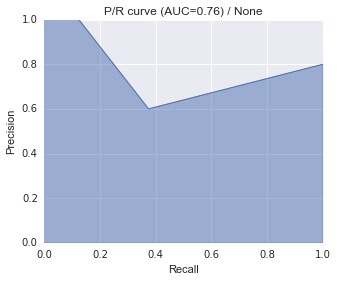

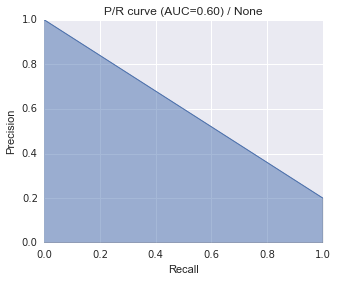

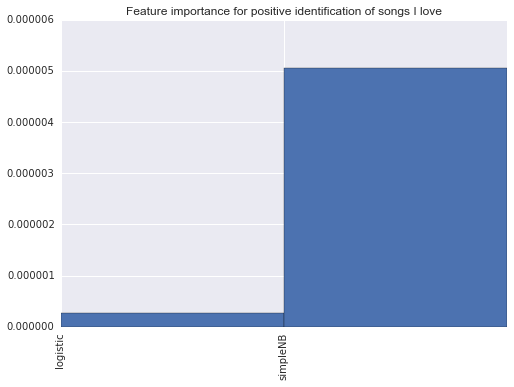

In [317]:
def plot_pr2(auc_score, precision, recall, label=None):
    plt.figure()
    plt.clf()
    plt.figure(num=None, figsize=(5, 4))
    plt.grid(True)
    plt.fill_between(recall, precision, alpha=0.5)
    plt.plot(recall, precision, lw=1)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('P/R curve (AUC=%0.2f) / %s' % (auc_score, label))

def fit_stacked(pos_label=1, n_folds=50):
    scores = []
    pr_scores = []
    precisions, recalls, thresholds = [],[],[]
    clfs = []

    for n in range(n_folds):

        split_idxs = np.array(random.sample(
                range(target_test.shape[0]), target_test.shape[0]/3))
        split_mask = np.ones(len(target_test), dtype=bool)
        split_mask[split_idxs] = False

        stack_tr = np.array([
                proba[split_mask,pos_idx],
                proba_NB[split_mask,pos_idx],
        #         proba_NB_union[split_mask,pos_idx]
            ]).T
        stack_test = np.array([
                proba[~split_mask,pos_idx],
                proba_NB[~split_mask,pos_idx],
        #         proba_NB_union[~split_mask,pos_idx]
            ]).T
        stack_tr_target = np.array(target_test[split_mask]).ravel()
        stack_test_target = np.array(target_test[~split_mask]).ravel()
        stack_logistic = LogisticRegressionCV(cv=10,
                                              scoring='f1')
        stack_logistic.fit(stack_tr, stack_tr_target)
        clfs.append(stack_logistic)
        stack_proba = stack_logistic.predict_proba(stack_test)

        precision, recall, pr_thresholds = precision_recall_curve(
                stack_test_target, 
                stack_proba[:,pos_label], 
                pos_label=pos_label)

        pr_scores.append(auc(recall, precision))
        precisions.append(precision)
        recalls.append(recall)
        thresholds.append(pr_thresholds)

    scores_to_sort = pr_scores
    median = np.argsort(scores_to_sort)[len(scores_to_sort)/2]

    plot_pr2(pr_scores[median],
                precisions[median],
                recalls[median])
    return clfs[median]

clf = fit_stacked(pos_label=1)
fit_stacked(pos_label=0)

plot_feature_importance(['logistic', 'simpleNB'], clf.coef_)


##Ordered Lists Of Songs

In [345]:
def predict_all_songs(clf, ret_label=1):
    pos_label=1
    prior_predictions = np.array([
         logistic.predict_proba(num_data)[:,pos_label],
         NB.predict_proba(text_data)[:,pos_label]
    ]).T
    
    all_songs = clf.predict_proba(prior_predictions)
    top_songs = np.argsort(all_songs[:,ret_label])
    top_songs = reversed(top_songs)
    return data.ix[top_songs][target_column]
print predict_all_songs(clf, ret_label=1)

